# N = 1000000, n_epochs = 101
# Apply Hypervolume to compare the results

### Modify equilibrium equations to reduce number of outputs

In [11]:
from pina import PINN, Condition, LabelTensor, Plotter
from pina.problem import SpatialProblem
from pina.operators import grad, div, nabla
from pina.model import FeedForward
from pina.geometry import CartesianDomain
from pina.equation.equation import Equation
from pina.equation.system_equation import SystemEquation
from pina.trainer import Trainer

import matplotlib.pyplot as plt

import numpy as np
import math
import torch
import sys

import faiss

### Create data points

In [12]:
# Create data points
def find_sqrt_matrix(input):
    evalues, evectors = torch.linalg.eig(input)
    sqrt_matrix = evectors * torch.sqrt(evalues) @ torch.linalg.inv(evectors)
    return sqrt_matrix.real

def symsqrt(matrix):
    _, s, v = matrix.svd()  # passes torch.autograd.gradcheck()
    above_cutoff = s > s.max() * s.size(-1) * torch.finfo(s.dtype).eps
    s = s[..., above_cutoff]
    v = v[..., above_cutoff]
    return (v * s.sqrt().unsqueeze(-2)) @ v.transpose(-2, -1)
def scale(C, x):
    return 1 / math.sqrt(2) * torch.matmul(C, x.T).mT.double()

E = 7
NU = 0.3

# Plane stress
# MU = E/(2*(1+NU))
# LAMBDA = E*NU/((1+NU)*(1-NU))

# Plane strain
MU = E/(2*(1+NU))
LAMBDA = E*NU/((1+NU)*(1-2*NU))

C = torch.zeros(3, 3)
C[0,0], C[1,1] = 1, 1
C[0,1], C[1,0] = NU, NU
C[2,2] = 1-NU
C = E/(1-NU*NU) * C
Cinv = torch.inverse(C)
Csqrt = find_sqrt_matrix(C)
Cinvsqrt = find_sqrt_matrix(Cinv)

# N = np.power(100, 3)
def create_data(ndata):
    data_eps = torch.distributions.Uniform(-0.1, 0.1).sample((ndata, 3))
    data_sig = torch.matmul(C, data_eps.T).mT
    data_eps_sc = scale(Csqrt, data_eps).float()
    data_sig_sc = scale(Cinvsqrt, data_sig).float()
    data_sc = torch.stack((data_eps_sc, data_sig_sc), dim=1).reshape(ndata, 6)
    return data_eps, data_sig, data_sc
N = 100000
data_eps, data_sig, data_sc = create_data(N)

# plt.scatter(data_eps[:, 0], data_sig[:, 0],
#             c='blue', edgecolors='none', s=30, label='xx')
# plt.scatter(data_eps[:, 1], data_sig[:, 1],
#             c='red', edgecolors='none', s=30, label='yy')
# plt.scatter(2*data_eps[:, 2], 2*data_sig[:, 2],
#             c='green', edgecolors='none', s=30, label='xy')
# plt.legend(loc=2)
# plt.xlabel('epsilon')
# plt.ylabel('sigma')
# plt.show()

vec_eps_hat = 1/math.sqrt(2) * torch.matmul(Csqrt, data_eps.T).mT
vec_sig_hat = 1/math.sqrt(2) * torch.matmul(Cinvsqrt, data_sig.T).mT
vec_eps_hat = torch.squeeze(vec_eps_hat)
vec_sig_hat = torch.squeeze(vec_sig_hat)
data = torch.cat([vec_eps_hat, vec_sig_hat], dim=1)

d = 6
nlist = 1000
k = 1
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist)
assert not index.is_trained
index.train(data)
assert index.is_trained
index.add(data)
index.nprobe = 100

### Parameters and Boundary Condition Functions

In [13]:
def initial_condition_left(input_, output_):
    exx, eyy, exy, sxx, syy, sxy, sxx_x, syy_y, sxy_x, sxy_y = \
        calculateSigmaAndEpsilon(input_, output_)
    value = 0.0
    return torch.hstack([sxx - value,sxy - value])

def initial_condition_bottom(input_, output_):
    exx, eyy, exy, sxx, syy, sxy, sxx_x, syy_y, sxy_x, sxy_y = \
        calculateSigmaAndEpsilon(input_, output_)
    value = 0.0
    return torch.hstack([syy - value,sxy - value])

def initial_condition_top(input_, output_):
    exx, eyy, exy, sxx, syy, sxy, sxx_x, syy_y, sxy_x, sxy_y = \
        calculateSigmaAndEpsilon(input_, output_)
    value = 0.0
    return torch.hstack([syy - value,sxy - value])

def initial_condition_right(input_, output_):
    exx, eyy, exy, sxx, syy, sxy, sxx_x, syy_y, sxy_x, sxy_y = \
        calculateSigmaAndEpsilon(input_, output_)
    value = 0.0
    return torch.hstack([sxx - torch.cos(input_.extract(['y'])*torch.pi*(1/2)), sxy - value])

def calculateSigmaAndEpsilon(input_, output_):
    dux = grad(output_, input_, components=['ux'])
    dduxdx = grad(dux, input_, components=['duxdx'])
    dduxdy = grad(dux, input_, components=['duxdy'])
    duy = grad(output_, input_, components=['uy'])
    dduydx = grad(duy, input_, components=['duydx'])
    dduydy = grad(duy, input_, components=['duydy'])

    ux_x = dux.extract('duxdx')
    ux_y = dux.extract('duxdy')
    uy_x = duy.extract('duydx')
    uy_y = duy.extract('duydy')

    ux_xx = dduxdx.extract('dduxdxdx')
    ux_xy = dduxdx.extract('dduxdxdy')
    ux_yx = dduxdy.extract('dduxdydx')
    ux_yy = dduxdy.extract('dduxdydy')
    uy_yy = dduydy.extract('dduydydy')
    uy_yx = dduydy.extract('dduydydx')
    uy_xy = dduydx.extract('dduydxdy')
    uy_xx = dduydx.extract('dduydxdx')

    exx = ux_x
    eyy = uy_y
    exy = 0.5 * (ux_y + uy_x)

    sxx = (2*MU + LAMBDA) * exx + LAMBDA * eyy
    syy = LAMBDA * exx + (2*MU + LAMBDA) * eyy
    sxy = 2 * MU * exy

    sxx_x = (2*MU + LAMBDA) * ux_xx + LAMBDA * uy_yx
    syy_y = (2*MU + LAMBDA) * uy_yy + LAMBDA * ux_xy
    sxy_y = MU * (ux_yy + uy_xy)
    sxy_x = MU * (ux_yx + uy_xx)

    return exx, eyy, exy, sxx, syy, sxy, sxx_x, syy_y, sxy_x, sxy_y


### Equilibrium and Min Distance Functions

In [14]:
equiblirium_res = []
equiblirium_res_fx = []
equiblirium_res_fy = []
min_dis_res = []

def equiblirium(input_, output_):
    exx, eyy, exy, sxx, syy, sxy, sxx_x, syy_y, sxy_x, sxy_y = \
        calculateSigmaAndEpsilon(input_, output_)
    fx = sxx_x + sxy_y
    fy = sxy_x + syy_y
    return torch.hstack([fx, fy])

def calculate_minimum_distance(input_, output_):
    exx, eyy, exy, sxx, syy, sxy, sxx_x, syy_y, sxy_x, sxy_y = \
        calculateSigmaAndEpsilon(input_, output_)

    vec_eps = torch.cat([exx, eyy, exy], dim=1).clone().detach()
    vec_sig = torch.cat([sxx, syy, sxy], dim=1).clone().detach()
    points = torch.cat([scale(Csqrt, vec_eps), scale(Cinvsqrt, vec_sig)], dim=1)

    D, I = index.search(points, k)

    residuals = torch.tensor(D)
    residuals.requires_grad_(True)
    min_dis_res.append(residuals)
    return residuals

### Residual Functions

In [15]:
def exposeResiduals_0(residual_tensor, n_epochs):
    # equiblirium_res = LabelTensor[(n_epochs*20) x n_gridpoints^2 x components]
    
    # Create empty list with length n_epochs
    residuals = []
    n_components = len(residual_tensor[0][0])
    for epoch in range(n_epochs):
        # Create zeros list with length n_components
        res_e = [0] * n_components
        # Each epoch trains n_batch times
        n_batches = int(len(residual_tensor)/n_epochs)
        for i in range(n_batches):
            gpoints_tensor = residual_tensor[epoch*n_batches + i]
            # Convert from LabelTensor to array for easier computing
            gpoints_array = gpoints_tensor.detach().numpy()
            # Take the sum of absolute values
            res_e = res_e + np.sum(np.square(gpoints_array), axis=0)
        # print('gpoints_array:', gpoints_array)
        # print('res_e:', res_e)
        # Save the mean result
        residuals.append((res_e/n_batches))
    return np.array(residuals)

def exposeResiduals(residual_tensor, n_epochs):
    # equiblirium_res = LabelTensor[(n_epochs*20) x n_gridpoints^2 x components]
    
    # Create empty list with length n_epochs
    residuals = []
    n_components = len(residual_tensor[0][0])
    for epoch in range(n_epochs):
        res_e = 0
        # Each epoch trains n_batch times
        n_batches = int(len(residual_tensor)/n_epochs)
        for i in range(n_batches):
            gpoints_tensor = residual_tensor[epoch*n_batches + i]
            gpoints_array = gpoints_tensor.detach().numpy()
            res_e = res_e + np.mean(
                np.mean(np.square(gpoints_array), axis=1),
                axis=0)
        # print('gpoints_array:', gpoints_array)
        # print('res_e:', res_e)
        # Save the mean result
        residuals.append((res_e/n_batches))
    return np.array(residuals)

### Create a NeuralNetwork with stress & strain Boundary Conditions

In [16]:
# Create a NeuralNetwork with stress & strain Boundary Conditions
class BVProblem(SpatialProblem):

    output_variables = ['ux', 'uy']
    spatial_domain = CartesianDomain({'x': [0, 1], 'y': [0, 1]})

    conditions = {
        'x0': Condition(
            location=CartesianDomain({'x': 0, 'y': [0, 1]}),
            equation=Equation(initial_condition_left)),
        'y0': Condition(
            location=CartesianDomain({'x': [0, 1], 'y': 0}),
            equation=Equation(initial_condition_bottom)),
        'x1': Condition(
            location=CartesianDomain({'x': 1, 'y': [0, 1]}),
            equation=Equation(initial_condition_right)),
        'y1': Condition(
            location=CartesianDomain({'x': [0, 1], 'y': 1}),
            equation=Equation(initial_condition_top)),
        'D': Condition(
            location=CartesianDomain({'x': [0, 1], 'y': [0, 1]}),
            equation=Equation(equiblirium)),
        'min_distance': Condition(
            location=CartesianDomain({'x': [0, 1], 'y': [0, 1]}),
            equation=Equation(calculate_minimum_distance)),
    }

bvp_problem = BVProblem()

### Create another NeuralNetwork with displacement Boundary Conditions

In [17]:
# Create another NeuralNetwork with displacement Boundary Conditions
n_hlayer = 20
class HardConstraintProblem(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.layers = torch.nn.Sequential(torch.nn.Linear(input_dim, n_hlayer),
                                          torch.nn.Tanh(),
                                          torch.nn.Linear(n_hlayer, n_hlayer),
                                          torch.nn.Tanh(),
                                          torch.nn.Linear(n_hlayer, n_hlayer),
                                          torch.nn.Tanh(),
                                          torch.nn.Linear(n_hlayer, n_hlayer),
                                          torch.nn.Tanh(),
                                          torch.nn.Linear(n_hlayer, output_dim))

    def forward(self, pts):
        output = self.layers(pts)
        # Modified: ux=0 when y=0 and uy=0 when x=0
        ux_hard = pts.extract(['y']) * output[:, 0][:, None]
        uy_hard = pts.extract(['x']) * output[:, 1][:, None]
        modified_output = torch.hstack([ux_hard, uy_hard])
        return modified_output

# model = FeedForward(
#     len(problem.input_variables),
#     len(problem.output_variables)
# )
model = HardConstraintProblem(
    len(bvp_problem.input_variables),
    len(bvp_problem.output_variables)
)

### Create some grid points

In [18]:
# Create some grid points
bvp_problem.discretise_domain(10, 'grid', locations=['x0','y0','x1','y1'])
bvp_problem.discretise_domain(20, 'grid', locations=['D', 'min_distance'])

# Create the solver
solver = PINN(problem=bvp_problem,
              model=model,
              optimizer=torch.optim.LBFGS)

n_epochs = 101
trainer = Trainer(
    solver=solver,
    kwargs={'max_epochs': n_epochs, 'accelerator': 'cpu'})
trainer.train()

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Kerem\.conda\envs\myPINA\lib\site-packages\lightning\pytorch\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name        | Type    | Params
----------------------------------------
0 | _loss       | MSELoss | 0     
1 | _neural_net | Network | 1.4 K 
----------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=101` reached.


### Plot total loss

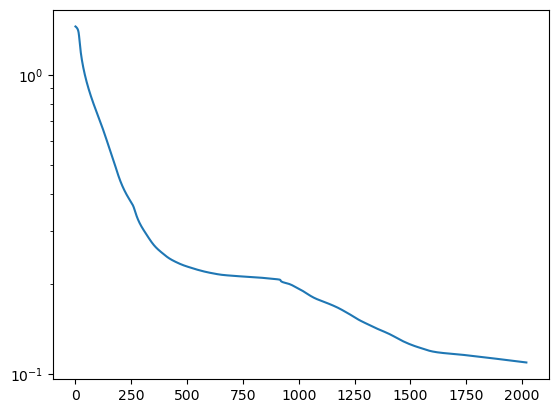

In [19]:
myloss = solver.loss_list
plt.yscale('log')
plt.plot(myloss)
plt.show()

### Plot local losses

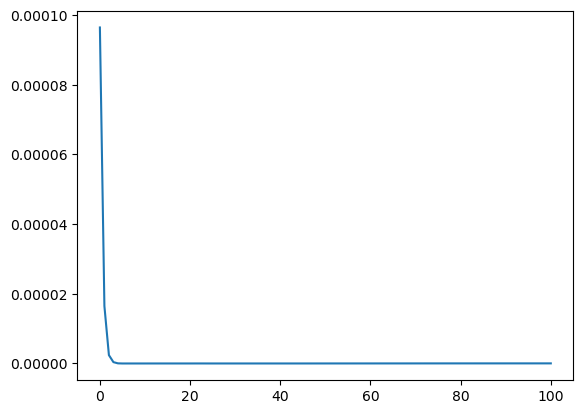

In [20]:
# Plot components
plotter = Plotter()
# plotter.plot(solver=solver, components='ux')
# plotter.plot(solver=solver, components='uy')

# Get and plot residuals
# equiblirium_res = LabelTensor[(n_epochs*20) x n_gridpoints^2 x components]

# res_fx = exposeResiduals(equiblirium_res_fx, n_epochs)
# plt.plot(res_fx)
# plt.show()
# res_fy = exposeResiduals(equiblirium_res_fy, n_epochs)
# plt.plot(res_fy)
# plt.show()

res_dis = exposeResiduals(min_dis_res, n_epochs)
plt.plot(res_dis)
plt.show()
